# 

[Insprired by](https://towardsdatascience.com/reinforcement-learning-implement-tictactoe-189582bea542), see also chapter 6.5 of Sutton etal. 

- https://towardsdatascience.com/simple-reinforcement-learning-q-learning-fcddc4b6fe56
- https://en.wikipedia.org/wiki/Q-learning
- https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/

In [20]:
from support_functions import *
import numpy as np
import dill
import itertools

In [2]:
tactoe = Tictoe(3)
tactoe.get_possible_next_moves()

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']

In [37]:
d = {'a': 1, 'b': 1, 'c': 0}
np.argmax(np.array(d.values()))
#np.argwhere()
a = np.array(list(d.values()))
#list(d.keys())[np.flatten(random.choice(np.argwhere(a == np.amax(a))))]
[1,2,3][int(random.choice(np.argwhere(a == np.amax(a))))]

1

# Make the Q-table

# Training against self

100%|██████████| 1000000/1000000 [13:30<00:00, 1234.22it/s]




2201
2097


<AxesSubplot:>

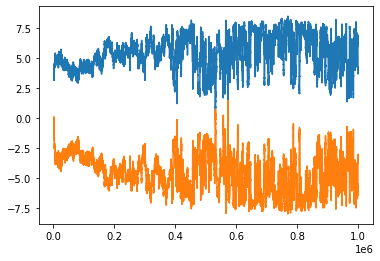

In [4]:
player1 = Player_vs_self(1, 
                 alpha = 0.1, 
                 gamma = 0.9,
                 epsilon = 0.1)
player2 = Player_vs_self(-1, 
                 alpha = 0.1,
                 gamma = 0.9, 
                 epsilon = 0.4)

# Training the policy
player1, player2, p1_rewards, p2_rewards, paths = play_tictactoe_vs_self(1000000, player1, player2, verbose=False)
print('\n')
print(len(player1.get_qtable()))
print(len(player2.get_qtable()))
pd.Series(p1_rewards).rolling(1000).mean().plot()
pd.Series(p2_rewards).rolling(1000).mean().plot()

In [ ]:
player1.get_qtable()

In [14]:
with open('player1.pkl', 'wb') as f:
    dill.dump(player1, f)

# Validation against self

In [103]:
# Validating the model. Setting epsilon to 0 ensures always using the optimal strategy

player1.set_params(epsilon = 0)
random_player = Player(1, epsilon=1.0)
player2.set_params(epsilon = 0)

player1, player2, p1_rewards, p2_rewards, paths = play_tictactoe(10, player1, player2, verbose=False)
pd.Series(p1_rewards).mean()

100%|██████████| 10/10 [00:00<00:00, 1286.40it/s]


10.0

# Training against tree

In [51]:
{0:2}[0]

2

In [54]:
class Player_vs_tree:
    def __init__(self, id, alpha = 0.5, gamma = 0.6, epsilon = 0.1, tree_file = 'tree_tctoe_3x3.pkl'):
        self.qtable = {}
        self.id = id
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.our_reward_lut = {10: -10, 5:5, 0:0, -10:10}
        
        print('Loading tree...')
        with open(tree_file, 'rb') as f:
            self.tree = dill.load(f)
            
        print('Precomputing best moves...')
        all_states = []
        for length in range(1,9):
            tree_states = [''.join(state) for state in list(itertools.permutations(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i'], r=length))]
            all_states.extend(tree_states)

        for state in tqdm(all_states):
            try:
                move = determine_move(self.tree, state, False) 
            except:
                pass
    def get_qtable(self):
        return self.qtable
    def get_id(self):
        return self.id
    def set_params(self, 
                   alpha = 0.5,       # How fast do we learn from new info
                   gamma = 0.6,       # How much are we focused on the short or the long term. 1 = max long term, 0 is max short term
                   epsilon = 0.1):    # exploration vs exploitation
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
    def make_move(self, game, verbose=False):
        if game.is_endstate():
            # If the game is done by the time we get to make a move, simply skip this step
            return game
        # Make a choice what move to take next
        possible_moves = game.get_possible_next_moves()
        current_state = game.get_current_state()
        
        # If the current_state does not exist in the qtable, insert it
        if current_state not in self.qtable:
            # New entry in the qtable, init to zero. 
            #self.qtable[current_state] = dict(zip([current_state + move for move in possible_moves], 
            #                                      np.random.uniform(0, 0.1, len(possible_moves))))  # initialize on a small amount of random noise. Promotes varyiety
            self.qtable[current_state] = dict(zip(possible_moves, 
                                                  np.zeros(len(possible_moves))))  
            
        # Insert epsilon choice here, exploit or explore
        if random.uniform(0, 1) < self.epsilon:
            new_state, reward, action = game.make_move(self.id, random.choice(possible_moves))   # Random choice
        else:  # Exploit our qtable
            new_state, reward, action = game.make_move(self.id, keywithmaxval(self.qtable[current_state]))   # Optimal choice
        
        if self.epsilon == 0:    # If we set epsilon to 0, we only want to play. No updating needed. 
            return game
        
        # When we play against the tree, we make the tree give us the next move it makes
        # so in essence we treat the tree as a black box that also changes the worldstate. 
        # And we also only learn from our own moves, and no longer access the alternative
        # qtable. 
        new_state_after_tree, reward_after_tree, action_after_tree = game.make_move(-1, determine_move(self.tree, game.get_moves_made(), False))
        
        # Update the qtable
        old_value = self.qtable[current_state][action]
        try:
            next_max = max(self.qtable[new_state_after_tree].values())
        except KeyError:  # In case the tree for next state has not been made yet, simply return 0
            next_max = 0
        # Note that the reward we actually get is the reward after the tree has made its move. We then reverse that reward vs the lut to get our own. 
        new_value = (1 - self.alpha) * old_value + self.alpha * (self.our_reward_lut[reward_after_tree] + self.gamma * next_max)
        if verbose:
            print('old: ', old_value, 'new_value: ', new_value, 'alpha: ', self.alpha, 'reward: ', self.our_reward_lut[reward_after_tree], 'gamma: ', self.gamma, 'next_max: ', next_max)
        self.qtable[current_state][action] = new_value

        if verbose:
            print(self.id, current_state, self.qtable[current_state], new_state_after_tree, action, old_value, new_value)
        
        return game

In [55]:

print(tictactoe.get_board())
#Player_vs_tree.make_move(tictactoe, True)
#print(tictactoe.get_board())

Loading tree...


  0%|          | 0/623529 [00:00<?, ?it/s]

Precomputing best moves...


100%|██████████| 623529/623529 [00:02<00:00, 283127.80it/s]

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [16]:
tictactoe.reset_board()

In [68]:
tictactoe = Tictoe(3)
player_tree = Player_vs_tree(1,
                            alpha = 0.01,
                            gamma = 0.8,
                            epsilon = 0.1)

no_episodes = 1000000
rewards = np.zeros(no_episodes)
for ep_idx in tqdm(range(no_episodes)):
    while not tictactoe.is_endstate():
        tictactoe = player_tree.make_move(tictactoe, False)
    rewards[ep_idx] = tictactoe.get_reward(1)
    tictactoe.reset_board()

Loading tree...


  0%|          | 0/623529 [00:00<?, ?it/s]

Precomputing best moves...


100%|██████████| 1000000/1000000 [13:05<00:00, 1272.63it/s]


<AxesSubplot:>

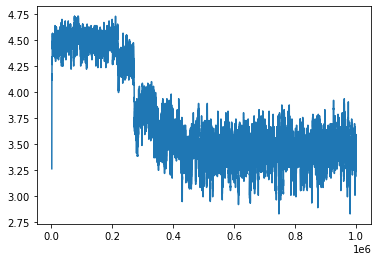

In [69]:
pd.Series(rewards).rolling(1000).mean().plot()

In [130]:
player_tree.get_qtable()

{'0d0e47938f6e00166e7352732ddfb7c610f44db2': {'a': 2.239999999999938,
  'b': 1.9999999999999545,
  'c': 2.239999999999938,
  'd': 1.9999999999999545,
  'e': 2.239999999999938,
  'f': 2.239999999999938,
  'g': 2.239999999999938,
  'h': 1.9999999999999545,
  'i': 2.239999999999938},
 '2d0581bcb9e82b4cc0a1f841fd80fcc0ea529cb8': {'c': -3.6685084900390907,
  'd': 3.199801857673547,
  'e': 3.1999999999999336,
  'f': -4.633268861441163,
  'g': 3.1999327436904856,
  'h': -3.840525973904568,
  'i': 3.199907744653526},
 '31ec6eee7a900a05851ce04ed6753f1bfb46e72e': {'c': -6.151039211065139,
  'd': -6.154367852533982,
  'e': -6.189528818954487,
  'h': -6.151039211065139,
  'i': -6.1630657207171105},
 '46287969f79eefb21f18c97d3993bd8af78195b2': {'d': -9.302849459598864,
  'e': -9.309820965002874,
  'h': -9.309820965002874},
 '3545f2d45900c425a5f38d45c6c77aa0803caa56': {'b': 3.1784199970099736,
  'c': 3.1999999999999336,
  'd': 3.1809566067238526,
  'f': 3.196231332792742,
  'g': 3.1992315608435975,


# Validate against tree

In [ ]:
print('Loading tree...')
with open('tree_tctoe_3x3.pkl', 'rb') as f:
    tree = dill.load(f)

100%|██████████| 10000/10000 [00:09<00:00, 1064.58it/s]


<AxesSubplot:>

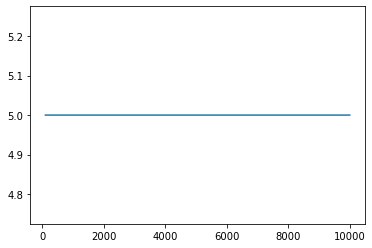

In [129]:
tictactoe = Tictoe(3)
player_solo_tree = Player_tree(tree, -1)
player_tree.set_params(epsilon = 0)

no_episodes = 10000
rewards = np.zeros(no_episodes)
for ep_idx in tqdm(range(no_episodes)):
    #print(ep_idx)
    while not tictactoe.is_endstate():
        tictactoe = player_tree.make_move(tictactoe, False)
        #print(tictactoe.get_board())
        if not tictactoe.is_endstate():
            tictactoe.make_move(-1, player_solo_tree.make_move(tictactoe.get_moves_made()))
        #print(tictactoe.get_board())
    rewards[ep_idx] = tictactoe.get_reward(1)
    tictactoe.reset_board()
pd.Series(rewards).rolling(100).mean().plot()

100%|██████████| 10000/10000 [00:06<00:00, 1604.30it/s]


<AxesSubplot:>

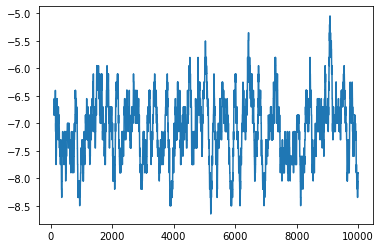

In [128]:
tictactoe = Tictoe(3)
player_solo_tree = Player_tree(tree, -1)
player_tree.set_params(epsilon = 0)  # <---- play randomly

no_episodes = 10000
rewards = np.zeros(no_episodes)
for ep_idx in tqdm(range(no_episodes)):
    #print(ep_idx)
    while not tictactoe.is_endstate():
        tictactoe.make_move(1, random.choice(tictactoe.get_possible_next_moves()))
        #print(tictactoe.get_board())
        if not tictactoe.is_endstate():
            tictactoe.make_move(-1, player_solo_tree.make_move(tictactoe.get_moves_made()))
        #print(tictactoe.get_board())
    rewards[ep_idx] = tictactoe.get_reward(1)
    tictactoe.reset_board()
pd.Series(rewards).rolling(100).mean().plot()

In [ ]:
rewards

In [77]:
player_solo_tree.make_move('a')

'e'

<AxesSubplot:>

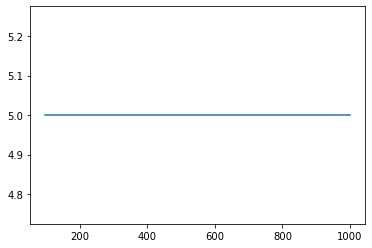

#### Manual play

In [66]:
tictactoe = Tictoe(3)

print('''Welcome to TicTacToe. 

You can make a move by selecting one of the following letters:''')
letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']
print(np.array(letters).reshape(3,3))
print('''You start, the computer will take the next move

Initial board:''')

player_tree.set_params(epsilon = 0)
move_history = ''
while not tictactoe.is_endstate():
    print('Computer is thinking')
    tictactoe = player_tree.make_move(tictactoe, verbose=True)
    print(tictactoe.get_board())
    
    if not tictactoe.is_endstate():
        player_move = input('Your move!: ')
        tictactoe.make_move(-1, player_move)
        print(tictactoe.get_board())

Welcome to TicTacToe. 

You can make a move by selecting one of the following letters:
[['a' 'b' 'c']
 ['d' 'e' 'f']
 ['g' 'h' 'i']]
You start, the computer will take the next move

Initial board:
Computer is thinking
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 1. 0.]]


Your move!:  e


[[ 0.  0.  0.]
 [ 0. -1.  0.]
 [ 0.  1.  0.]]
Computer is thinking
[[ 1.  0.  0.]
 [ 0. -1.  0.]
 [ 0.  1.  0.]]


Your move!:  g


[[ 1.  0.  0.]
 [ 0. -1.  0.]
 [-1.  1.  0.]]
Computer is thinking
[[ 1.  0.  0.]
 [ 1. -1.  0.]
 [-1.  1.  0.]]


Your move!:  c


[[ 1.  0. -1.]
 [ 1. -1.  0.]
 [-1.  1.  0.]]


# Validation against tree

In [2]:
import dill
import numpy as np

with open('player1.pkl', 'rb') as f:
    player1 = dill.load(f)

In [3]:
with open('tree_tctoe_3x3.pkl', 'rb') as f:
    tree = dill.load(f)

In [4]:
import itertools
from tqdm import tqdm
import treelib

letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']

class Player_tree:
    def __init__(self, tree, id):
        self.tree = tree
        self.id = id
    def make_move(self, moves_made):
        if self.id == -1:
            return determine_move(self.tree, moves_made, False)
        else:
            return determine_move(self.tree, moves_made, True)

import itertools
from tqdm import tqdm
import treelib

all_states = []
for length in range(1,9):
    tree_states = [''.join(state) for state in list(itertools.permutations(letters, r=length))]
    all_states.extend(tree_states)

for state in tqdm(all_states):
    try:
        move = determine_move(tree, state, True) 
    except:
        pass

100%|██████████| 623529/623529 [00:59<00:00, 10486.97it/s] 


In [6]:
player_tree = Player_tree(tree, -1)
player_tree.make_move('a')

'e'

In [39]:
tictactoe = Tictoe(3)

player_tree.set_params(epsilon = 0)
move_history = ''
while not tictactoe.is_endstate():
    print('Computer is thinking')
    tictactoe = player_tree.make_move(tictactoe, verbose=True)
    print(tictactoe.get_board())
    
    if not tictactoe.is_endstate():
        tictactoe.make_move(-1, player_tree.make_move(tictactoe.get_moves_made()))
        print(tictactoe.get_board())

Computer is thinking
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]]
Computer is thinking
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 1. 1.]]
Computer is thinking
[[0. 0. 1.]
 [0. 0. 0.]
 [0. 1. 1.]]
Computer is thinking
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 1.]]


In [108]:
tictactoe = Tictoe(3)

print('''Welcome to TicTacToe. 

You can make a move by selecting one of the following letters:''')
letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']
print(np.array(letters).reshape(3,3))
print('''You start, the computer will take the next move

Initial board:''')

player1.set_params(epsilon = 0)
move_history = ''
while not tictactoe.is_endstate():
    print('Computer is thinking')
    tictactoe = player1.make_move(tictactoe, {}, verbose=True)
    print(tictactoe.get_board())
    
    if not tictactoe.is_endstate():
        player_move = input('Your move!: ')
        tictactoe.make_move(-1, player_move)
        print(tictactoe.get_board())

Welcome to TicTacToe. 

You can make a move by selecting one of the following letters:
[['a' 'b' 'c']
 ['d' 'e' 'f']
 ['g' 'h' 'i']]
You start, the computer will take the next move

Initial board:
Computer is thinking
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]]


Your move!:  c


[[ 0.  0. -1.]
 [ 0.  0.  0.]
 [ 0.  0.  1.]]
Computer is thinking
[[ 0.  0. -1.]
 [ 0.  0.  0.]
 [ 0.  1.  1.]]


Your move!:  g


[[ 0.  0. -1.]
 [ 0.  0.  0.]
 [-1.  1.  1.]]
Computer is thinking
[[ 0.  1. -1.]
 [ 0.  0.  0.]
 [-1.  1.  1.]]


Your move!:  e


[[ 0.  1. -1.]
 [ 0. -1.  0.]
 [-1.  1.  1.]]


In [194]:
#import dill

#with open('player1_block_aebc.pkl', 'wb') as player_file:
#    dill.dump(player1, player_file)

# Insights tijdens dev

- Ik begon met een state die afhankelijk was van de volgorde waarin je op die state uitkwam. De key was dan bv 'ebad'. Maar we willen eigenlijk helemaal niet. Het probleem is hier dat we dan een veel te grote state space krijgen, en alleen maar gaan leren als we specifiek op die bepaalde stand op het bord komen via een specifieke route. Nu kijken we alleen naar stand op het bord. 
- Hash algo 'str' is erg traag, 3x penalty in performance. 
- De learning rate had ik erg hoog.
- Paden bijhouden levert veel op qua inzicht in wat er precies gebeurt
- Ik begon met alleen leren op de eigen qtable. Maar we leren met twee agents tegelijkertijd. Dus we moeten ook de rewards van de andere player kunnen inzien. Daar moeten we dan minmax achtig op reageren, i.e. als hij hoog scoort dan geeft die state een negatieve reward. 

# Nog te doen
- Trainen tegen betere tegenstander, tegen zichzelf is wel shit. Bijvoorbeeld de treesearch die we eerder maakten. Of een soort bootstrap. 
    - Geprobeerd: player 2 een hogere epsilon. Dan speelt nr1 tegen een meer random tegenstander. 
- Meer optimale hash code, [bv deze](https://stackoverflow.com/questions/806151/how-to-hash-a-large-object-dataset-in-python/806342#806342)
- Wat verkennend werk doen rondom de hyperparams alpha, gamma en epsilon. 
- Betere validatie dan weer tegen zichzelf. Bv tegen de treesearch zou goed zijn. 
    - Validatie met de tree laat zien dat de RL-agent het beter dan een random agent doet. 
    - Helaas opent de RL-agent altijd met dezelfde zet, waarbij de volgende zet door de tree ook vaststaat. En je krijgt dus altijd het zelfde potje. 

\begin{equation}
Q^{new}(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha (r_t + \gamma \cdot \max_a(s_{t+1}, a) - Q(s_t, a_t))
\end{equation}

where:

- $Q^{new}(s_t, a_t)$, is the new Q-value for the given action-value pair for state $s_t$ and action $a_t$. 
- $Q(s_t, a_t)$, the previous Q-value that was recorded in the Q-table.
- $\alpha$ the learning rate. How heavily should the new Q-value be influenced by what we are going to learn in this new step?
- $r_t$ the (short-term) reward we got for taking the $\epsilon$-greedy step. 
- $max_a(s_{t+1}, a)$ is the estimate of optimal future value for state $s_{t+1}$, i.e. the maximum Q value for that state $s_{t+1}$. 

A slight rewrite of the function yields additional insight:

\begin{equation}
Q^{new}(s_t, a_t) \leftarrow (1-\alpha) Q(s_t, a_t) + \alpha r_t + \alpha\gamma \max_a(s_{t+1}, a)
\end{equation}

where:
- $(1-\alpha) Q(s_t, a_t)$ is the current value of Q weighted by the learning rate. So, if the learning rate is zero, the new value is simply the old value. This essentially means the algorithm is not learning anything new. An alpha value of 1 simply discards this old value and completely relies on the new Q value calculated by the other terms. Values in between 0 and 1 allow you to control how fast learning progresses. A balance between learning fast enough, but not getting overly focused on short term gains is part of the challenge. 
- $\alpha r_t$ the short-term reward we got from taking the $\epsilon$-greedy action we took. Like before, an $\alpha$ of 1 ensures completely focusing on the short-term reward, and an $\alpha$ of 0 completely disregards what reward we got. 
- $\alpha\gamma \max_a(s_{t+1}, a)$ the largest potential future Q-value we could obtain in the actions that follow this particular state. It hints towards the potential (long-term) value taking action $a_t$ in state $s_t$. 

So, to update the value $Q$ of taking action $a_t$ given a state $s_t$ we balance the old value we got versus the short term reward and the potential long-term value the next steps after this action provides. 